In [54]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [55]:
# Ignore deprecation warnings
import warnings
warnings.filterwarnings("ignore")

## Data Loading and Exploration

In [89]:
# Import libraries
from PIL import Image
import xgboost as xgb
import matplotlib.pyplot as plt
from tokenizers import BertWordPieceTokenizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import plotly.express as px
import plotly.figure_factory as ff
from plotly import graph_objs as go

from tqdm import tqdm
from tqdm.notebook import tqdm

import transformers
from transformers import TFBertModel

from collections import Counter
from collections import defaultdict

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import spacy
from spacy.util import compounding
from spacy.util import minibatch

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import ModelCheckpoint

import keras
from keras.optimizers import Adam
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import (LSTM, Embedding, BatchNormalization, Dense,
                          TimeDistributed, Dropout, Bidirectional,
                          Flatten, GlobalMaxPool1D)

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                             confusion_matrix, classification_report,
                             accuracy_score, roc_auc_score)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import re, random, string

In [57]:
# Read and describe data
df = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding="latin-1")
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [58]:
# Label columns and preview data
df = df.dropna(how="any", axis=1)
df.columns = ['target', 'message']
df.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [59]:
# Add a column for message lengths
df['message_len'] = df['message'].apply(lambda x: len(x.split(' ')))
df.head()

,target,message,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


In [60]:
# Store word lengths for target categories
ham_df = df[df['target'] == 'ham']['message_len'].value_counts().sort_index()
spam_df = df[df['target'] == 'spam']['message_len'].value_counts().sort_index()

In [61]:
# Store grouped counts of unique values in 'target' column
bal_counts = df.groupby('target')['target'].agg('count').values

In [62]:
# Create a bar chart showing distribution by target categories
fig = go.Figure()
fig.add_trace(go.Bar(x = ['Ham'],
    y = [bal_counts[0]],
    name = 'Ham',
    text = [bal_counts[0]]))
fig.add_trace(go.Bar(x = ['Spam'], y = [bal_counts[1]],
                     name = 'Spam', text = [bal_counts[1]]))
fig.update_layout(title='Dataset Distribution by Target')
fig.show()

In [63]:
# Plot simple line charts for word length distribution in categories
fig = go.Figure()
fig.add_trace(go.Scatter(x = ham_df.index, y = ham_df.values,
                         name = 'Ham', fill = 'tozeroy'))
fig.add_trace(go.Scatter(x = spam_df.index, y = spam_df.values,
                         name = 'Spam', fill = 'tozeroy'))
fig.update_layout(title = 'Word Length Distribution by Target')
fig.update_xaxes(range = [0, 70])
fig.show()

## Text Preprocessing

In [64]:
# Define clean text function
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [65]:
# Define remove stopwords function
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

In [66]:
# Define stemming function
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [67]:
# Apply defined functions to clean and prepare data
df['cleaned_message'] = df['message'].apply(clean_text)
df['cleaned_message'] = df['cleaned_message'].apply(remove_stopwords)
df['cleaned_message'] = df['cleaned_message'].apply(stemm_text)
df.head()

,target,message,message_len,cleaned_message
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though


In [68]:
# Encode target
le = LabelEncoder()
le.fit(df['target'])

df['encoded_target'] = le.transform(df['target'])
df.head()

,target,message,message_len,cleaned_message,encoded_target
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...,0
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...,1
3,ham,U dun say so early hor... U c already then say...,11,dun say earli hor alreadi say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though,0


## Token Visualization

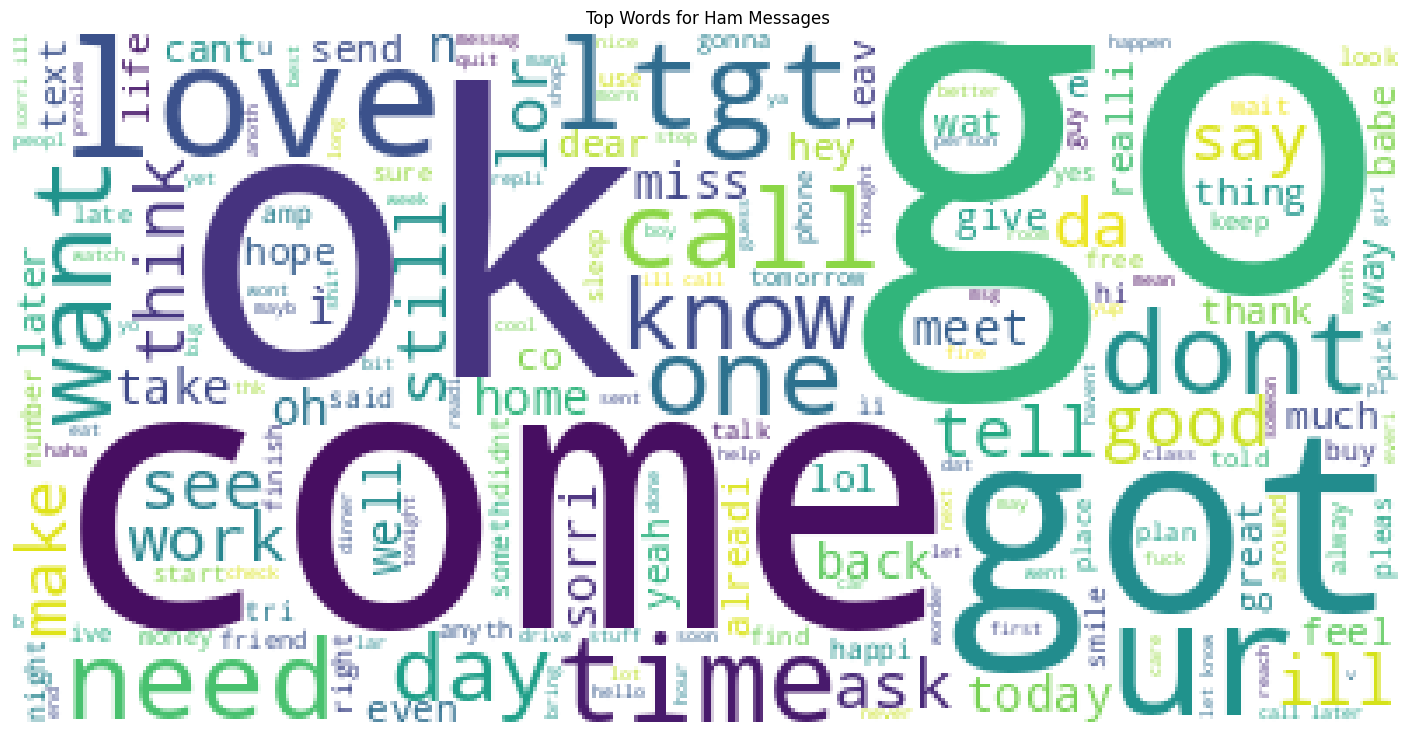

In [69]:
wc = WordCloud(background_color = 'white', max_words = 200)
wc.generate(' '.join(text for text in df.loc[df['target'] == 'ham', 'cleaned_message']))

plt.figure(figsize = (18, 10))
plt.imshow(wc)
plt.title('Top Words for Ham Messages')
plt.axis("off")
plt.show()

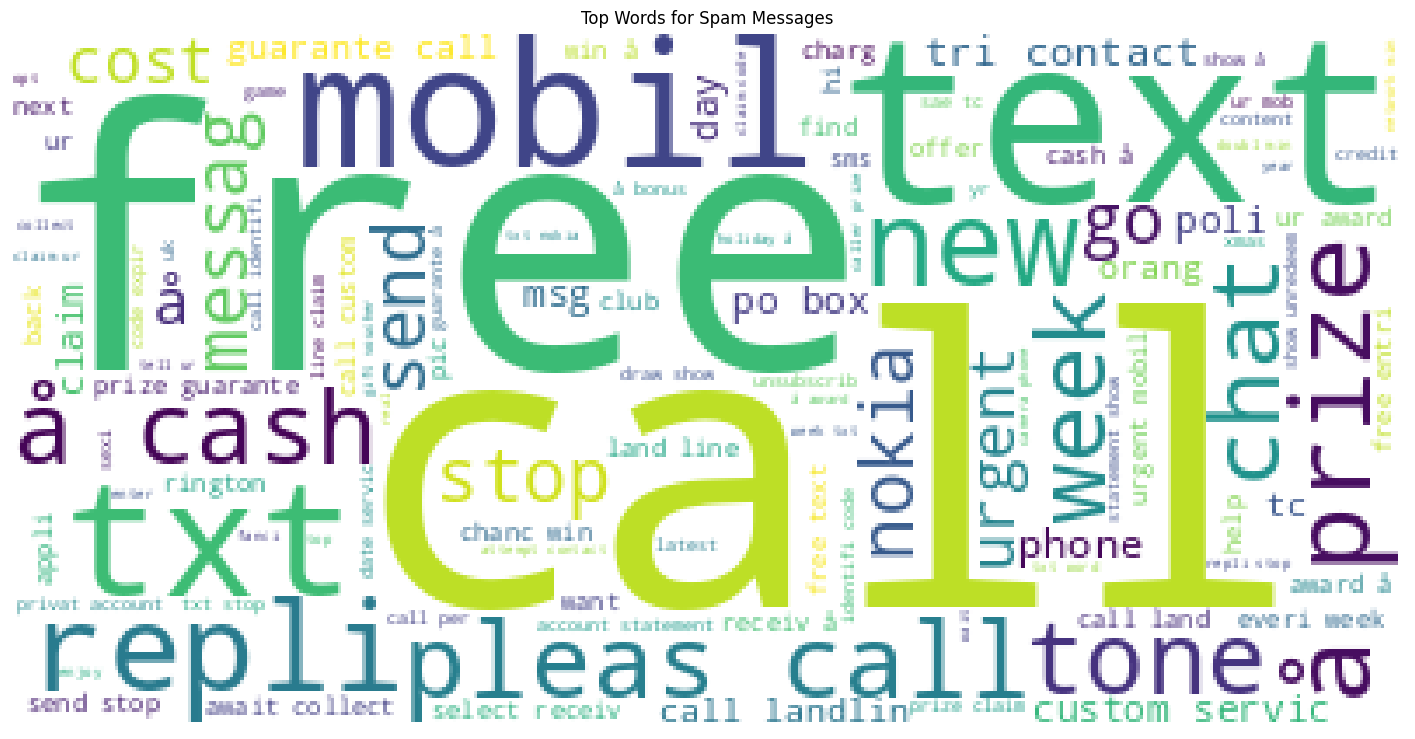

In [70]:
wc = WordCloud(background_color = 'white', max_words = 200)
wc.generate(' '.join(text for text in df.loc[df['target'] == 'spam', 'cleaned_message']))

plt.figure(figsize = (18, 10))
plt.imshow(wc)
plt.title('Top Words for Spam Messages')
plt.axis("off")
plt.show()

## Vectorization

In [71]:
# Split into train and test sets
x = df['cleaned_message']
y = df['encoded_target']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

4179 4179
1393 1393


In [72]:
# Initiate the CountVectorizer
vect = CountVectorizer()
vect.fit(x_train)

CountVectorizer()

In [73]:
# Create a document-term matrix from train and test sets
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

In [74]:
# Define and run CountVectorizer object
vect_tunned = CountVectorizer(stop_words = 'english', ngram_range = (1, 2),
                              min_df = 0.1, max_df = 0.7, max_features = 100)

In [75]:
# Compute IDF Values using a TF-IDF Transformer
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(x_train_dtm)
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)

## TF-IDF Transformer

## Word Embeddings: GloVe

In [76]:
# Define base columns
texts = df['cleaned_message']
target = df['encoded_target']

In [77]:
# Calculate the length of vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)
vocab_length = len(word_tokenizer.word_index) + 1

In [78]:
# Transform list of sequences into a 2D Numpy array
longest_train = max(texts, key = lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    word_tokenizer.texts_to_sequences(texts), 
    length_long_sentence, 
    padding = 'post'
)

In [79]:
# Implement GloVe
embeddings_dictionary = dict()
embedding_dim = 100

with open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

In [80]:
# Load embedding vectors of words that appear in GloVe
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.57832998, -0.0036551 ,  0.34658   , ...,  0.070204  ,
         0.44509   ,  0.24147999],
       [-0.078894  ,  0.46160001,  0.57779002, ...,  0.26352   ,
         0.59397   ,  0.26741001],
       ...,
       [ 0.63009   , -0.036992  ,  0.24052   , ...,  0.10029   ,
         0.056822  ,  0.25018999],
       [-0.12002   , -1.23870003, -0.23303001, ...,  0.13658001,
        -0.61848003,  0.049843  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## Model Building

In [81]:
# Define a function to generate confusion matrices
x_axes = ['Ham', 'Spam']
y_axes =  ['Spam', 'Ham']

def conf_matrix(z, x = x_axes, y = y_axes):
    z = np.flip(z, 0)
    z_text = [[str(y) for y in x] for x in z]
    fig = ff.create_annotated_heatmap(z, x = x, y = y, annotation_text = z_text)
    fig.update_layout(title_text = 'Confusion Matrix',
                      xaxis = dict(title = 'Predicted value'),
                      yaxis = dict(title = 'Real value')
                     ) 

    fig['data'][0]['showscale'] = True
    return fig

In [82]:
# Create and train Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

nb.fit(x_train_dtm, y_train)

MultinomialNB()

### Naive Bayes DTM

In [85]:
# Make class and probability predictions
y_pred_class = nb.predict(x_test_dtm)
y_pred_prob = nb.predict_proba(x_test_dtm)[:, 1]
print(accuracy_score(y_test, y_pred_class))
conf_matrix(confusion_matrix(y_test, y_pred_class))

0.9784637473079684


In [90]:
# Calculate AUC
roc_auc_score(y_test, y_pred_prob)

0.9745842444094048

### Naive Bayes

In [91]:
# Define pipeline
pipe = Pipeline([('bow', CountVectorizer()),
                 ('tfid', TfidfTransformer()),
                 ('model', MultinomialNB())])

In [92]:
# Fit pipeline with data
pipe.fit(x_train, y_train)
y_pred_class = pipe.predict(x_test)
print(accuracy_score(y_test, y_pred_class))
conf_matrix(confusion_matrix(y_test, y_pred_class))

0.9597989949748744


### XGBoost

In [93]:
# Define pipeline
pipe = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfid', TfidfTransformer()),  
    ('model', xgb.XGBClassifier(
        learning_rate = 0.1,
        max_depth = 7,
        n_estimators = 80,
        use_label_encoder = False,
        eval_metric = 'auc',
        # colsample_bytree = 0.8,
        # subsample = 0.7,
        # min_child_weight = 5,
    ))
])

In [94]:
# Fit pipeline with data
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)
y_pred_train = pipe.predict(x_train)

print('Train: {}'.format(accuracy_score(y_train, y_pred_train)))
print('Test: {}'.format(accuracy_score(y_test, y_pred_class)))

conf_matrix(confusion_matrix(y_test, y_pred_class))

Train: 0.9830102895429529
Test: 0.964824120603015


### LSTM

In [96]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    target, 
    test_size = 0.25
)

In [97]:
# Define GloVe & LSTM model
def glove_lstm():
    model = Sequential()
    
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights = [embedding_matrix], 
        input_length=length_long_sentence
    ))
    
    model.add(Bidirectional(LSTM(
        length_long_sentence, 
        return_sequences = True, 
        recurrent_dropout=0.2
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = glove_lstm()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 100)           676900    
                                                                 
 bidirectional (Bidirection  (None, 80, 160)           115840    
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 160)               0         
 alMaxPooling1D)                                                 
                                                                 
 batch_normalization (Batch  (None, 160)               640       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                        

In [98]:
# Load the model and train
model = glove_lstm()

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)

history = model.fit(
    X_train, 
    y_train, 
    epochs = 7,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/7
131/131 [==============================] - ETA: 0s - loss: 0.3242 - accuracy: 0.8693
Epoch 1: val_loss improved from inf to 0.28454, saving model to model.h5
131/131 [==============================] - 21s 124ms/step - loss: 0.3242 - accuracy: 0.8693 - val_loss: 0.2845 - val_accuracy: 0.9383 - lr: 0.0010
Epoch 2/7
131/131 [==============================] - ETA: 0s - loss: 0.1967 - accuracy: 0.9337
Epoch 2: val_loss improved from 0.28454 to 0.17412, saving model to model.h5
131/131 [==============================] - 16s 123ms/step - loss: 0.1967 - accuracy: 0.9337 - val_loss: 0.1741 - val_accuracy: 0.9304 - lr: 0.0010
Epoch 3/7
131/131 [==============================] - ETA: 0s - loss: 0.1476 - accuracy: 0.9576
Epoch 3: val_loss improved from 0.17412 to 0.11928, saving model to model.h5
131/131 [==============================] - 16s 119ms/step - loss: 0.1476 - accuracy: 0.9576 - val_loss: 0.1193 - val_accuracy: 0.9591 - lr: 0.0010
Epoch 4/7
131/131 [============================

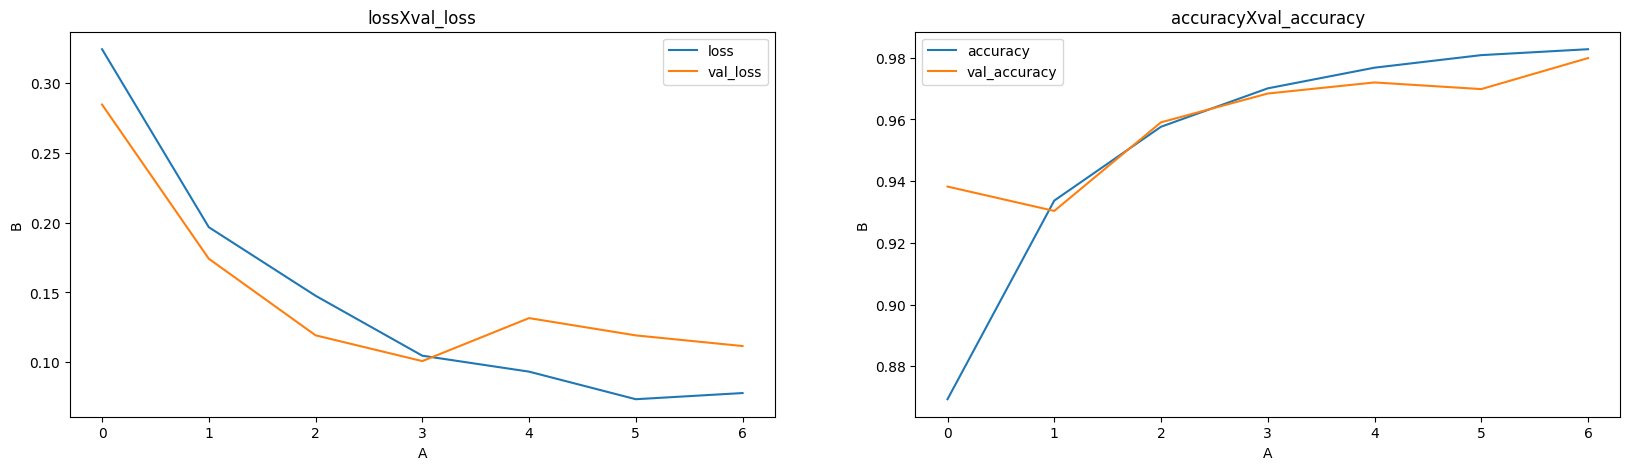

In [99]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize = (20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]])
        ax[idx].set_xlabel('A')
        ax[idx].set_ylabel('B')
        ax[idx].set_title(arr[idx][0] + 'X' + arr[idx][1])

plot_learning_curves(history, [['loss', 'val_loss'], ['accuracy', 'val_accuracy']])

In [100]:
y_preds = (model.predict(X_test) > 0.5).astype("int32")
conf_matrix(confusion_matrix(y_test, y_preds))

44/44 [==============================] - 2s 23ms/step


### BERT

In [102]:
# Define BERT encoding function
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text, 
            add_special_tokens = True,
            max_length = maximum_length,
            pad_to_max_length = True,

            return_attention_mask = True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids), np.array(attention_masks)

In [104]:
texts = df['cleaned_message']
target = df['encoded_target']

train_input_ids, train_attention_masks = bert_encode(texts, 60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [105]:
# Define BERT model
def create_model(bert_model):
    input_ids = tf.keras.Input(shape = (60,), dtype = 'int32')
    attention_masks = tf.keras.Input(shape = (60,), dtype = 'int32')
    
    output = bert_model([input_ids,  attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32, activation = 'relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1, activation = 'sigmoid')(output)
    
    model = tf.keras.models.Model(inputs = [input_ids, attention_masks], outputs = output)
    model.compile(Adam(lr = 1e-5), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [106]:
model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 60, 76                                           
                             8),                                                              

In [108]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    target,
    validation_split = 0.2, 
    epochs = 1,
    batch_size = 10
)

446/446 [==============================] - 1625s 4s/step - loss: 0.4208 - accuracy: 0.8643 - val_loss: 0.3919 - val_accuracy: 0.8700
